Данная работа посвящена изучению пропускной способности каналов с мягкими решениями $C_S(M, \mu_S^2)$

Очевидно $C_S(M, \mu_S^2) \le \frac{log_2{M^N}}{N} = log_2 M$

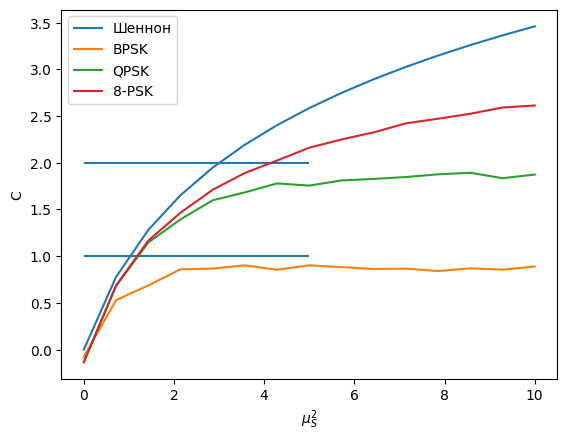

In [15]:
import matplotlib.pyplot as plt
from math import sqrt
import numpy as np

def max_C(mu_s2 : float | np.ndarray):
    return np.log2(1 + mu_s2)

# Базовый класс, задающий распределение непрерывной 
# случайной величины в комплексной плоскости 
class Distribution:
    # возвращает sample(массив выборок) размера size
    def __call__(self, size = 1):
        return np.zeros(size)

# Нормальное распределение Z = X + jY, X,Y ~ N(0, sigma^2) => D[Z] = 2sigma^2
class ComplexNormalDistribution(Distribution):
    def __init__(self, sigma = 1.0):
        self.sigma = sigma

    def __call__(self, size = 1):
        X = np.random.normal(0, self.sigma, size)
        Y = np.random.normal(0, self.sigma, size)
        return X + 1j*Y
    
# Численно находит плотности распределения в заданных точках
def get_density(sample : np.ndarray, k : int):
    N = len(sample)
    # Матрица расстояний
    distances = np.abs(sample[:, np.newaxis] - sample[np.newaxis, :])
    sorted_distances = np.sort(distances, axis=1)
    # расстояние до k-ой ближайшей точки
    epsilon_k = sorted_distances[:, k]
    rho = k / (N * np.pi * epsilon_k * epsilon_k)
    return rho

# находит дифференциальную энтропию как -E[log(rho(x))] методом Монте-Карло, учитывая k-го соседа для вычисления плотности
def h(sample : np.ndarray, k : int):
    return -float(np.sum(np.log2(get_density(sample, k)))) / len(sample)

# Y = C + N, N ~ ComplexNormalDistribution
class AWGNChannel:
    def __init__(self, sigma : float):
        self.N = ComplexNormalDistribution(sigma)
        self.sigma = sigma

    # вычисление взаимной информации I(C,Y)
    def get_I(self, C : Distribution):
        return h(self.get_Y(C, 5000), 200) - np.log2(2*np.pi*np.e*self.sigma*self.sigma)

    # возвращает sample выходного распределения размера size
    def get_Y(self, C : Distribution, size = 1):
        return C(size) + self.N(size)
    
class Constellation(Distribution):
    def __init__(self, symbols : list[complex]):
        self.symbols = symbols
    def __call__(self, size = 1):
        return np.random.choice(self.symbols, size)

channel = AWGNChannel(1/sqrt(2)) # mu_s^2 = E[C^2]

def BPSK_C(mu_s2 : float):
    mu_s = sqrt(mu_s2)
    BPSK = Constellation([-mu_s, mu_s])
    return channel.get_I(BPSK)

def QPSK_C(mu_s2 : float):
    mu_s = sqrt(mu_s2)
    BPSK = Constellation([-mu_s, mu_s, -1j*mu_s, 1j*mu_s])
    return channel.get_I(BPSK)

def PSK8_C(mu_s2 : float):
    mu_s = sqrt(mu_s2)
    PSK8 = Constellation([np.exp(1j*2*np.pi*k/8)*mu_s for k in range(8)])
    return channel.get_I(PSK8)

def xarg(func, args):
    result = []
    for arg in args:
        result.append(func(arg))
    return result

mu2 = np.linspace(0, 10, 15)
plt.plot(mu2, max_C(mu2), label="Шеннон")
plt.hlines([1, 2], 0, 5)
plt.plot(mu2, xarg(BPSK_C, mu2), label="BPSK")
plt.plot(mu2, xarg(QPSK_C, mu2), label="QPSK")
plt.plot(mu2, xarg(PSK8_C, mu2), label="8-PSK")
plt.xlabel(r"$\mu_S^2$")
plt.ylabel("C")
plt.legend()
plt.show()